In [1]:
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['C:\\Users\\user\\PycharmProjects\\Open_Close_GNN'])

Python 3.7.16 (default, Jan 17 2023, 16:06:28) [MSC v.1916 64 bit (AMD64)] on win32


In [2]:
from model.dataset import OpenCloseDataset
from model.gnn_model import GCN, GATv2
import os
from model.utils import train, device, train_epoch, eval_epoch, cross_val
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torch_geometric.loader import DataLoader

from captum.attr import Saliency

from seaborn import heatmap

In [3]:
close_file = np.load('../data/new/raw/close_84.npy') 
open_file  = np.load('../data/new/raw/open_84.npy')

noised_close = np.load('../data/new/raw/noised_close.npy')
noised_open  = np.load('../data/new/raw/noised_open.npy')

In [4]:
full_dataset = OpenCloseDataset(datafolder='../data/new', 
                                open_file=open_file, close_file=close_file, 
                                reload=True, k_degree=None, threshold=0.3,
                                noise_n=25, noise_close=noised_close, noise_open=noised_open)

Processing...
Done!


<AxesSubplot:>

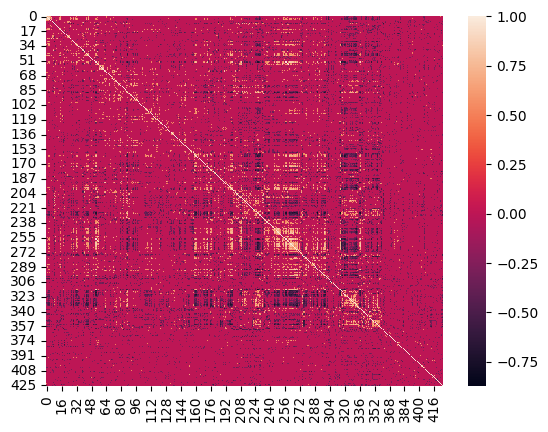

In [105]:
heatmap(((-0.25 > open_file[0]) + (0.5 < open_file[0]))* open_file[0])

<AxesSubplot:>

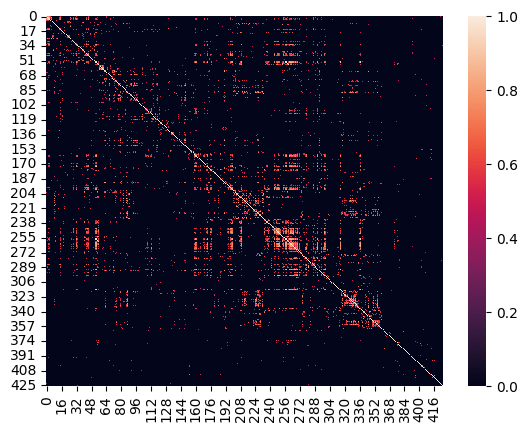

In [106]:
heatmap(np.abs(open_file[0] > 0.5) * open_file[0])

In [6]:
test_idx = np.random.choice(np.arange(84*2, dtype=int), 20).tolist()
train_idx = np.delete(np.arange(len(full_dataset)), test_idx).tolist()
test_dataset = full_dataset[test_idx[:10]]
train_dataset = full_dataset[train_idx]
val_dataset = full_dataset[test_idx[10:]]

In [7]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

In [8]:
model = GCN(full_dataset.num_features, channels=[128, 32], dropout=0.5).to(device())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()
epochs = 10
scheduler = lr_scheduler.StepLR(optimizer, step_size=epochs//3, gamma=0.1, last_epoch=-1, verbose=True)
sum(p.numel() for p in model.parameters())

Adjusting learning rate of group 0 to 1.0000e-03.


58594

In [9]:
model.load_state_dict(torch.load('..\weights\gcn_128_32_05_acc_09.pt', map_location='cuda:0'))

<All keys matched successfully>

In [10]:
history = train(model, epochs, train_loader, val_loader, loss, optimizer, 
                scheduler=None, save_best=True, path_to_save='../weights/gcn_128_32_05.pt')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 001, Train Loss: 0.0287, Test Loss 0.0580, Train Acc: 0.9900, Test Acc: 1.0000
Test precision: 1.0000, Test recall: 1.0000
Epoch: 002, Train Loss: 0.0155, Test Loss 0.0454, Train Acc: 1.0000, Test Acc: 1.0000
Test precision: 1.0000, Test recall: 1.0000
Epoch: 003, Train Loss: 0.0077, Test Loss 0.0336, Train Acc: 1.0000, Test Acc: 0.9375
Test precision: 1.0000, Test recall: 0.9286
Epoch: 004, Train Loss: 0.0035, Test Loss 0.0670, Train Acc: 1.0000, Test Acc: 0.7500
Test precision: 1.0000, Test recall: 0.7500
Epoch: 005, Train Loss: 0.0021, Test Loss 0.0271, Train Acc: 1.0000, Test Acc: 0.9375
Test precision: 1.0000, Test recall: 0.9286
Epoch: 006, Train Loss: 0.0012, Test Loss 0.0490, Train Acc: 1.0000, Test Acc: 0.9375
Test precision: 1.0000, Test recall: 0.9286
Epoch: 007, Train Loss: 0.0008, Test Loss 0.0230, Train Acc: 1.0000, Test Acc: 0.9375
Test precision: 1.0000, Test recall: 0.9286
Epoch: 008, Train Loss: 0.0005, Test Loss 0.0267, Train Acc: 1.0000, Test Acc: 0.9375
Test

In [11]:
test_loader = DataLoader(test_dataset)
eval_epoch(test_loader, model, loss)
# loss, acc, precision, recall

(0.1133753707865253, 1.0, 0.6, 0.6)

In [12]:
[i for i, en in enumerate(test_dataset) if en.y == 1]

[1, 2, 3, 4, 7, 8]

In [59]:
from captum.attr import Saliency, IntegratedGradients
from torch import exp

model.to('cpu')

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to('cpu')
    out = model(data.x, data.edge_index, edge_mask, batch)
    return out


def explain(method, data, target=0):
    data.to('cpu')
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to('cpu')
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask


idx = 9
edge_mask = explain(method='saliency', data=test_dataset[idx], target=test_dataset[idx].y)

In [60]:
list(zip(edge_mask, *data.edge_index))

[(0.064778805, tensor(0), tensor(0)),
 (0.0063784095, tensor(0), tensor(1)),
 (0.054474317, tensor(0), tensor(2)),
 (0.030089812, tensor(0), tensor(3)),
 (0.06351421, tensor(0), tensor(4)),
 (0.09957609, tensor(0), tensor(5)),
 (0.26012236, tensor(0), tensor(6)),
 (0.28068972, tensor(0), tensor(7)),
 (0.20615944, tensor(0), tensor(10)),
 (0.23456502, tensor(0), tensor(11)),
 (0.03582222, tensor(0), tensor(12)),
 (0.23114392, tensor(0), tensor(13)),
 (0.2589979, tensor(0), tensor(14)),
 (0.21869442, tensor(0), tensor(15)),
 (0.28269872, tensor(0), tensor(18)),
 (0.1819323, tensor(0), tensor(21)),
 (0.20177014, tensor(0), tensor(22)),
 (0.27174085, tensor(0), tensor(23)),
 (0.21595553, tensor(0), tensor(24)),
 (0.15714887, tensor(0), tensor(25)),
 (0.06538298, tensor(0), tensor(26)),
 (0.04531086, tensor(0), tensor(27)),
 (0.117936045, tensor(0), tensor(29)),
 (0.33230782, tensor(0), tensor(30)),
 (0.077595145, tensor(0), tensor(31)),
 (0.37174514, tensor(0), tensor(33)),
 (0.071212254, 

In [ ]:
edge_mask_dict = defaultdict(float)
for val, u, v in list(zip(edge_mask, *data.edge_index)):
    u, v = u.item(), v.item()
    if u > v:
        u, v = v, u
    edge_mask_dict[(u, v)] += val

In [79]:
from collections import defaultdict
def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        # todo symmetrical?
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict

edge_dict = aggregate_edge_directions(edge_mask, test_dataset[0])

In [80]:
matr = np.zeros((422, 422))
for k in edge_dict:
    matr[k[0], k[1]] = edge_dict[k]


<AxesSubplot:>

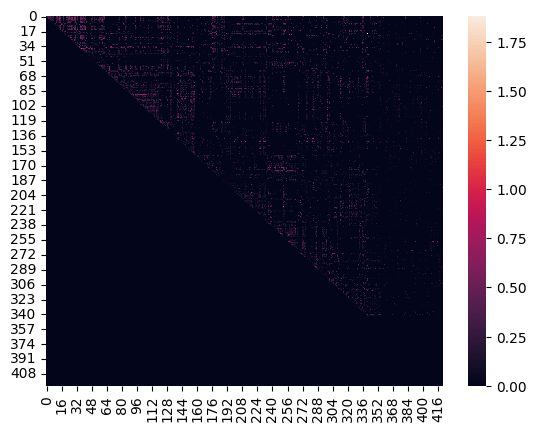

In [81]:
heatmap(matr)

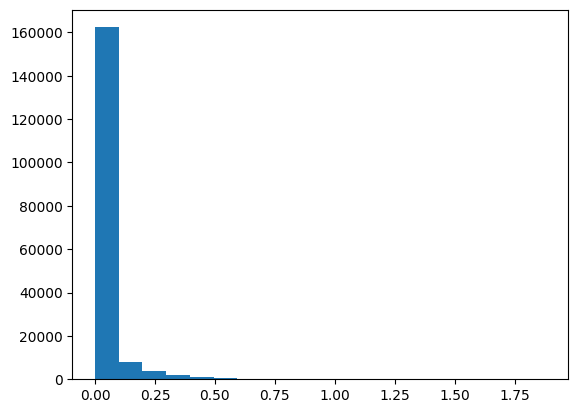

In [89]:
plt.hist(np.where(matr,matr,matr.T).flatten(), bins='auto');

<AxesSubplot:>

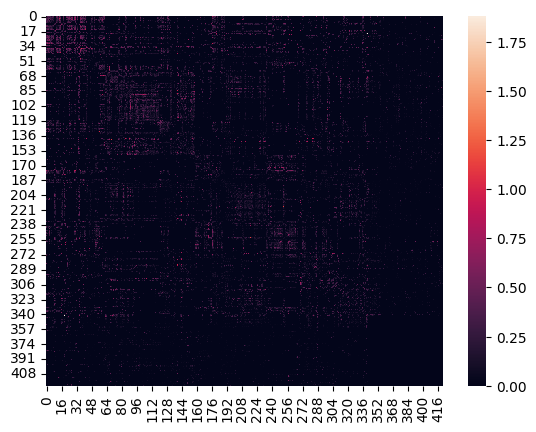

In [32]:
heatmap(np.where(matr,matr,matr.T))

In [35]:
idx = 9
edge_mask_ig = explain(method='ig', data=test_dataset[idx], target=test_dataset[idx].y)
edge_dict_ig = aggregate_edge_directions(edge_mask_ig, test_dataset[0])

<AxesSubplot:>

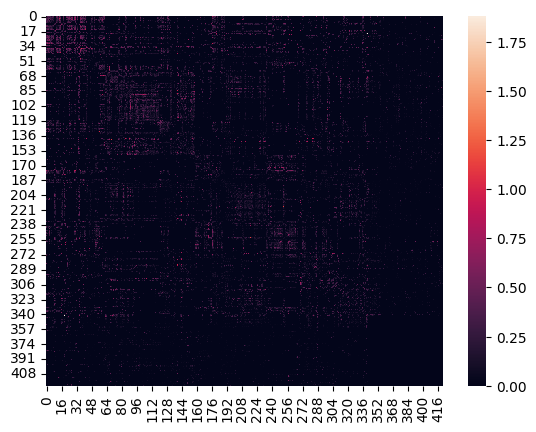

In [36]:
matr_ig = np.zeros((422, 422))
for k in edge_dict:
    matr_ig[k[0], k[1]] = edge_dict_ig[k]

heatmap(np.where(matr_ig, matr_ig, matr_ig.T))


In [44]:
import pandas as pd

hcp = pd.read_excel('../data/HCPex_sorted.xlsx')
hcp.drop([256, 257, 258, 259], inplace=True)


In [47]:
hcp.head(20)

,Index,ID,Label,Cortical Division,R,G,B,X,Y,Z
0,0,1,Primary_Visual_Cortex_L,Primary_Visual,208,216,117,-10.078,-84.159,1.759
1,1,181,Primary_Visual_Cortex_R,Primary_Visual,208,216,117,-12.044,-82.059,4.029
2,2,2,Second_Visual_Area_L,Early_Visual,231,50,224,-16.607,-84.793,7.259
3,3,182,Second_Visual_Area_R,Early_Visual,231,50,224,-29.556,-86.009,-1.542
4,4,3,Third_Visual_Area_L,Early_Visual,33,58,133,-24.456,-74.776,38.047
5,5,183,Third_Visual_Area_R,Early_Visual,33,58,133,-15.327,-90.377,27.933
6,6,4,Fourth_Visual_Area_L,Early_Visual,233,44,241,-27.171,-81.718,17.571
7,7,184,Fourth_Visual_Area_R,Early_Visual,233,44,241,-15.102,-79.083,30.836
8,8,5,IntraParietal_Sulcus_Area_1_L,Dorsal_Stream_Visual,162,59,163,-21.277,-85.896,42.021
9,9,185,IntraParietal_Sulcus_Area_1_R,Dorsal_Stream_Visual,162,59,163,-24.517,-86.382,29.849


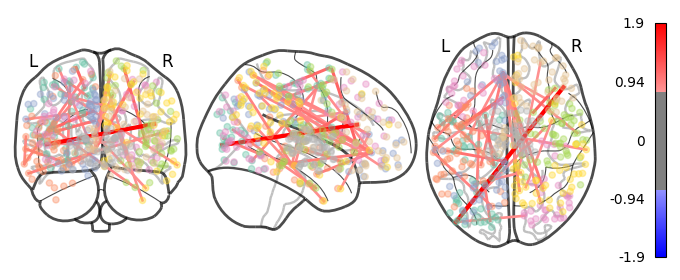

In [86]:
from nilearn.plotting import plot_connectome

plot_connectome(np.where(matr, matr, matr.T), hcp[['X', 'Y', 'Z']].values, 
                node_size=20, edge_threshold=0.8, colorbar=True, node_kwargs={'alpha': 0.4});

positional encoding

In [16]:
coords = hcp[['X', 'Y', 'Z']].values

coords.shape

(422, 3)

In [27]:
coords_reshaped = coords.reshape((1, 3, 422))[:, :, np.newaxis, np.newaxis, :].copy()

In [19]:
import torch
from positional_encodings.torch_encodings import PositionalEncoding1D, PositionalEncoding2D, PositionalEncoding3D, Summer

# Returns the position encoding only
p_enc_1d_model = PositionalEncoding1D(10)

# Return the inputs with the position encoding added
p_enc_1d_model_sum = Summer(PositionalEncoding1D(10))

x = torch.rand(1,6,10)
penc_no_sum = p_enc_1d_model(x) # penc_no_sum.shape == (1, 6, 10)
penc_sum = p_enc_1d_model_sum(x)
print(penc_no_sum + x == penc_sum) # True

tensor([[[True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True]]])


In [22]:
torch.zeros((1,3,1,1,422))

tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.]]]]])

In [29]:
p_enc_3d = PositionalEncoding3D(422)
p_enc_3d(torch.from_numpy(coords_reshaped))

tensor([[[[[ 0.0000,  1.0000,  0.0000,  ...,  1.0000,  0.0000,  1.0000]]],


         [[[ 0.8415,  0.5403,  0.7697,  ...,  1.0000,  0.0000,  1.0000]]],


         [[[ 0.9093, -0.4161,  0.9828,  ...,  1.0000,  0.0000,  1.0000]]]]],
       dtype=torch.float64)

In [21]:
z

tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
 

In [7]:
p_enc_1d_model

PositionalEncoding1D()